In [11]:
import SimpleITK as sitk
import os 
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.models import *

class L3LocModel(nn.Module):
    def __init__(self, N_neighbor=2, d_model=512):
        super().__init__()
        
        backbone = resnet18(pretrained=False)
        backbone.conv1 = nn.Conv2d(1, backbone.conv1.out_channels,
                                  kernel_size=backbone.conv1.kernel_size,
                                  stride=backbone.conv1.stride,
                                  bias=backbone.conv1.bias)
        self.pool = None
        self.cnn = nn.Sequential(*list(backbone.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.0),
            nn.Linear(d_model*(1+2*N_neighbor), d_model),
            nn.Linear(d_model, 1)
        )
        self.N_neighbor = N_neighbor

    def forward(self, x, N_lst=None):
        # x: (B, N, 3, 96, 96)
        B, N, C, H, W = x.shape
        x = x.view(B*N, C, H, W)
        cnn_feat = self.cnn(x)
        if self.pool:
            cnn_feat = self.pool(cnn_feat)
        cnn_feat = cnn_feat.view(B, N, 1, -1) # (B, N, 1, 512)
        
        feat = []
        for n in range(-self.N_neighbor, self.N_neighbor+1): # (-2, -1, 0, 1, 2)
            if n <= 0: 
                tmp = cnn_feat[:, abs(n):, ...]
                tmp = torch.cat([tmp, torch.zeros(B, abs(n), *cnn_feat.shape[-2:]).float().to(cnn_feat.device)], dim=1)
            else: 
                tmp = cnn_feat[:, :-n, ...]
                tmp = torch.cat([torch.zeros(B, n, *cnn_feat.shape[-2:]).float().to(cnn_feat.device), tmp], dim=1)
            feat.append(tmp)
        feat = torch.cat(feat, dim=2) # (B, N, 1+2*N_neighbor, 512)
        feat = feat.view(B, N, -1)
        pred = self.classifier(feat).squeeze(dim=2)
        return pred

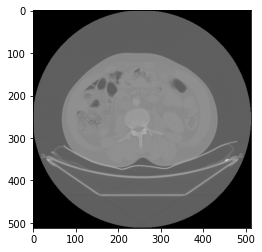

In [21]:
def inference(model, image, window_level=250, window_width=1000, target_size=96):
    hu_lower = window_level - window_width/2
    hu_higher = window_level + window_width/2
    
    image = image.clip(hu_lower, hu_higher)
    image = ((image - hu_lower) / (hu_higher - hu_lower) * 255).astype(np.uint8)
    tmp = image[image.shape[0]//2]
    ind = np.where(tmp)
    y1, y2 = min(ind[0]), max(ind[0])
    x1, x2 = min(ind[1]), max(ind[1])
    image = image[:, y1:y2, x1:x2]
    image = torch.Tensor(image).unsqueeze(dim=1) # (N, 1, H, W)
    X = F.interpolate(image, size=(target_size, target_size), mode="bilinear") # (N, 1, 96, 96)
    
    X = X.unsqueeze(dim=0).float()
    with torch.no_grad():
        p = model(X)
        p = torch.softmax(p, dim=1)
    slice_id = torch.argmax(p, dim=1)[0].item()
    return slice_id


model_file = "Results/L3LocModel_resnet18_True_2_L3LocDataset/best.pth"
model = L3LocModel()
model.load_state_dict(torch.load(model_file, map_location="cpu"))
model.eval()

file = np.random.choice(glob("Data/L3LocData/*.nii.gz"), 1)[0]
image = sitk.GetArrayFromImage(sitk.ReadImage(file))
slice_id = inference(model, image)
plt.imshow(image[slice_id], cmap="gray")
plt.show()
plt.close()